Candidate: 213

CNN is a type of deep learning algorithm commonly used for image and video processing applications. it is designet to autmatically and adaptively learn spatial hierarchies of features from input data.

Training a convolutional neural network (CNN) as a binary classifier of one category in a dataset involves several steps:
1. Data preperation
2. Model architecture
3. Loss function
4. Optimizer
5. Training
6. Validation
7. Testing

Training a convolutional neural network (CNN) as a binary classifier means creating a model that can classify whether an input image belongs to a particular category or not. For instance, let's say we want to classify images of cats versus non-cat images, and our goal is to build a binary classifier that can differentiate between these two categories.

To achieve this, we can use a pre-trained CNN, which is a CNN that has already been trained on a large dataset, such as ImageNet, and has learned to extract relevant features from images. We can then fine-tune this pre-trained model on our own dataset of cat and non-cat images, by adjusting its weights to better fit our specific problem.

Alternatively, if we have sufficient computational power, we can build our own complete CNN from scratch, which involves designing and training a new network architecture specifically for our binary classification task. This would involve selecting appropriate layers, such as convolutional layers, pooling layers, and fully connected layers, and tuning their hyperparameters, such as the number of filters, filter sizes, and learning rates, to achieve the best performance on our dataset.

Overall, the goal is to build a CNN model that can accurately classify images as belonging to the chosen category or not, by leveraging pre-trained models or designing our own from scratch.

I. Split the dataset: Divide the dataset into training and validation sets. The training set is used to train the model, while the validation set is used to monitor the model's performance and prevent overfitting.

II. Define the model: Define a CNN architecture that can learn to classify the images as belonging to the positive or negative class. This typically involves defining the number and types of layers, specifying the activation functions, and setting the hyperparameters (e.g. learning rate, batch size, number of epochs, etc.).

III. Compile the model: Compile the model by specifying the loss function, optimizer, and evaluation metrics. For a binary classification problem, the binary cross-entropy loss function and the Adam optimizer are common choices.

IV. Train the model: Train the model on the training set. During training, the model learns to recognize patterns in the input images that are associated with the positive or negative class.

V. Evaluate the model: Evaluate the model's performance on the validation set using the evaluate() method. This provides an estimate of how well the model will generalize to new, unseen data.

VI. Test the model: Test the model's performance on the test set. This is important to ensure that the model is abel to genralize well and make accurate predictions on new unseen data and in end imporve the model.

VII. Make predictions: Use the trained model to make predictions on new, unseen data using the predict() method.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import *
import numpy as np
import torch.nn as nn
from torch.optim import Adam, SGD
from torch import *
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import cv2
import os

## pip install 

pip install opencv-python

pip install os-sys

pip install imbalanced-learn

Module for over-sampling and under-sampling techniques for imbalanced datasets. Like SMOTE that have used.

### 1. Data preparation

Since this is a binary classification problem, we need to make sure the labels are 1 for the true label meaning the one label I want to train the model to recognize and 0 for all other labels.
That is exactly what this class is for, it is used so that I can convert the multi-class target variable into a binary variable. It takes a single argument pos_label, which will be specified as the chosen positive class label that will be converted to 1. All other classes will be converted to 0. The CIFAR10 dataset has 10 classes, and I have chosen class frog as my true class.
The call and init methods initialize class instances and help convert inputs to an integer.


In [2]:
class ToBinary(object):
    def __init__(self, pos_label):
        self.pos_label = int(pos_label)

    def __call__(self, y):
        y = int(y)
        if y == self.pos_label:
            return 1
        else:
            return 0

In data preparation I am downloading the CIFAR10 dataset online and extracting the training data and testing data separately. We need to apply transformation pipeline using transforms and compose function from the PyTorch library. The pipeline consists of two transformations where we convert the image data to tensors and normalize which normalizes the tensor data with mean and standard deviation values of 0.5 for each channel. Then we create an instance of ToBinary class to change the labels to the positive class. 

In [3]:
# chain together a sequence of image transformation to be applied to the dataset, in this case ToTensor()
# that converts the image into a pytorch tensor and normalize the pixel values of the image to have a mean of 0.5 and a standard deviation of 0.5, so that the pixel values fall within the range [-1, 1].
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
) 

to_binary = ToBinary(pos_label=6)

# apply the ToBinary transformation to the target labels

# download the CIFAR10 dataset for training and validation
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform, target_transform=to_binary)

# download the CIFAR10 test_dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform, target_transform=to_binary)

Files already downloaded and verified
Files already downloaded and verified


Before any other pre-processing measurements are taken, we need to make sure the dataset is split into training, validation, and testing sets. Since we have our own test dataset, thanks to the CIFAR10, we only need to split the training dataset into validation. The testing set from is length 10000 meaning validation has to have the same length as well so I can have the distribution (80/10/10). The reason this is done is because if we want to do any other further pre-processing techniques this is only done on the training set, since the model needs to be balanced to learn properly. After this we only validate and test how well the model can predict, and the data does not necessarily have to be balanced for this. Since it is evaluating the performance of the model on data it has not seen before and we don’t have any gradients that can tune the hyperparameter while validating/testing. So, we don’t want to improve but understand how the improved model on training set can predict other unknown data. This will be elaborated under.

In [4]:
# Split the dataset into 60% training, 20% validation sets, and 20% testing sets.  
n = len(dataset)
train_size = int(0.8 * n)
val_size = n - train_size

# which are subsets of the original dataset. To access the indices of the subsets, you can use the .indices
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], torch.Generator().manual_seed(42))

Here we apply SMOTE algorithm to address the class imbalance in the training data for this classification task. It is inevitable we would get this problem, as I said above, we want 1 class out of 10 meaning the true class will be the minority and this is extremely bad while training. 
The input images and targets from the training set are extracted into two tensors using a list comprehension and the torch.stack() and torch.tensor() functions. Then since we have class imbalance, we check how imbalanced it is using unique(). Then we check since there is more than 1 class (2) SMOTE is applied to oversample the minority class. The SMOTE object is created from imblearn library and the random_state argument is set to ensure reproducibility. To resample we call the fit_resample function on the flattened input tensor X and target tensor y are converted to numpy arrays. A new dataset is created using resampled data class, otherwise the original training data is used. Then the new resampled data is reshaped into the original image dimensions using reshape. 
Finally, data loaders are applied for training, validation and testing sets that are created. The train loader is balanced as it contains the resampled training set, the other loaders contain their own sets respectfully. They each have batch size of 32 and we applied shuffle only during training and validation. For testing it does not affect the evaluation of the model’s performance. This was really hard to figure out what to do as oversampling is tricky and can even result in overfitting or other problems. I tought it was still better to do oversampling than undersampling as i read many article that explained removing data can result in bad accuracy as we may loose important data. Altough before something like this is considered it depends on what the problem is and if it if better to add more data or just remove it if it does not harm the model.


In [5]:
# Also making sure each subgropup of interest is represented
# My apporach is oversampeling the minority class 1 
# extract the input features X and target labels y for the training set
X = torch.stack([data[0] for data in train_dataset])
y = torch.tensor([data[1] for data in train_dataset])

# check the number of classes in y
num_classes = len(torch.unique(y)) # has to be 2 for SMOTe to be applied

# apply SMOTE to the training data to oversample the minority class as follows
if num_classes > 1:
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X.reshape(X.shape[0], -1).numpy(), y.numpy())
else:
    X_resampled, y_resampled = X.numpy(), y.numpy()

# create a new training dataset with the resampled data
train_dataset_resampled = TensorDataset(torch.tensor(X_resampled.reshape(X_resampled.shape[0], 3, 32, 32)), torch.tensor(y_resampled))

# defining the data loaders for the training and validation
# sampler is because oversampling technique is used to address class imbalance during training
train_loader = DataLoader(train_dataset_resampled, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

#### Visualizing data on each batch (on the balanced training set).

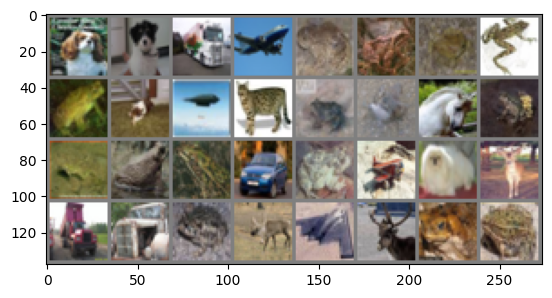

non-frog non-frog non-frog non-frog frog  frog  frog  frog  frog  non-frog non-frog non-frog frog  frog  non-frog frog  frog  frog  frog  non-frog frog  non-frog non-frog non-frog non-frog non-frog frog  non-frog non-frog non-frog frog  frog 


In [6]:
classes = ['non-frog', 'frog']

def imshow(img):
    img = img / 2 + 0.5 # unormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get random training images
dataiter = iter(train_loader)
im, lab = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(im))
# print labels
print(' '.join(f'{classes[lab[j]]:5s}' for j in torch.arange(32)))

### 2. Model architecture

This Convolutional Neural Network is designed from scratch using sequential which is from the troch library. We start off by having 3 input channels for the colour channel. Then we have height and width of 32x32 and padding 1. Relu activation is always applied after each convolutional layer, it returns the input if it is positive and returns 0 if it is negative. Then there is also maxpool at the end of each layer, this takes the input and returns half the size of the tensor that was inputted. In the fully connected layers, I have added some dropout this was after I originally made the model to help reduce overfitting, the flatten is always used before being fed into the fully connected layer. It flattens the input to 1D tensor. Then in the fully connected layer we apply linear transformation we apply the size of the input features as the whole tensor, and output feature is based on the last input feature. The model has 2 output features based on the binary labelling there are classes labels 0 and 1. There is also a possibility to have one output feature and then use sigmoid/softmax to squash the output between 1 for high probability and 0 for low probability it is the correct class. But this is all based on the type of loss function that is going to be used. Initially we had one output feature and the binary loss function, but I switched so that I could use the cross-entropy loss function that is for multi classification problems as well was binary classification if there are 2 output channels. The last layer does not have either SoftMax or sigmoid, so the model will just give its prediction it belongs to each class.

In [14]:
# To define a CNN architecture for image classification we typically use a combination of convolutional, pooling, and fully connected layers.
# The number and types of layers, as well as the activation functions, are chosen based on the spesific task and dataset.
# CNN architecture for binary image classification:

class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            #inp = 3 x 32 x 32, out = 32 x 32 x 32
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(), # linear activation function. output the input if porsitive, otherwise it outputs zero
            nn.MaxPool2d(2, 2), # downsampeling, reduces the dimensions (height and width) of the input. 32x32 becomes 16x16

            # inp = 32 x 16 x 16, out = 64 x 16 x 16
            nn.Conv2d(32, 64, 3, padding=1), 
            nn.ReLU(), 
            nn.MaxPool2d(2, 2),

            # inp = 64 x 8 x 8
            nn.Dropout(p=0.3),
            nn.Flatten(), # flattens input to 1D tensor. used before being fed into a fully connected layer
            nn.Linear(64 * 8 * 8, 128), # applies linear transformation to the input tensor
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 2)
            # output (p0, p1) where p0 is prob that input belongs to class 0 and p1 is prob that input belongs to class 1
        )

    def forward(self, x): 
        return self.model(x)

### 3 & 4. Loss function and Optimizer

Since the classes are now balanced and have two output channels in the fully connected layer, we are using CorssEntropyLoss as a binary classification loss function. 
We don’t need to add a sigmoid or softmax activation function to the output of the model because the loss function applies it internally. 
There are loss functions for binary (one output channel) like BCELoss, but we won’t use BCELoss as it is more suitable for cases where the two classes are not balanced.
The optimizer is also added, we are using Adam because it is suited for all kinds of problems. We have experimented with the numbers of the learning rate and decay to find the optimal result, and these numbers was the ones that gave us high prediction and metrics.  
The device is also set, if there is GPU available it will run on that other than that it runs on CPU.


In [15]:
# create an instance of the neural network, loss, optimizer
clf = BinaryClassifier()
loss_fn = nn.CrossEntropyLoss()
opt = Adam(clf.parameters(), lr=0.0001, weight_decay=0.00001) 
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 5. Training

This training function is specially made so that it can be used while training and evaluating. The function has parameters for mode so whether it is training or validation, then there is loader based on the training and validation. Then we initialize the running loss. Based on if it is training it will have the gradients on, and if validation we don’t need this, and the gradients are zeroed out. The output is then calculated in the model and loss function is calculated from the output and label. Also, the backward pass and updating the weights is only applied  during training. 
Then the running loss is calculated for the whole batch one by one and the average loss for each batch is returned. 

In [16]:
# function for training/validation/testing
def work(mode, loader):
    if mode == 'train':
        # set model to train mode
        clf.train()
    else:
        # set model to eval mode
        clf.eval()

    # initialize metrics
    running_loss = 0.0

    # iterate over the data loader
    for inputs, labels in loader:
        # move data to device 
        inputs = inputs.to(dev)
        labels = labels.to(dev)

        # zero out gradients
        opt.zero_grad()

        # forward pass
        # torch.set_grad_enabled(True) truned on only for training
        # then we calculate output while training otherise if false it is evaluation and using no gradients
        with torch.set_grad_enabled(mode == 'train'):
            outputs = clf(inputs)
            loss = loss_fn(outputs, labels)

            # backward pass and update weights only when training
            if mode == 'train':
                loss.backward()
                opt.step()

        # update metrics
        running_loss += loss.item() * inputs.size(0)

    # calculate average metrics
    epoch_loss = running_loss / len(loader.dataset)

    return epoch_loss

### 6. Validation

Here the training loop and validation loop is run, then we print the statistics of the loss so that we can monitor what is happening. Making sure the loss doesn’t increase so that we are experiencing overfitting or underfitting. The reason we check if validation loss has improved is because if the model makes the validation loss increase it means that it has learn everything it can and does not perform well on new data. And if this happens for many epochs there is no need to run anymore so we applied stopping mechanism based on this. Then if it does improve, we want to save this so we can apply it for testing on new unseen data. Therefor while validating we did do some hyperparameter tuning, this is where the most changes came from. Like applying SMOTE and changing of the loss function.

In [10]:
n_epoch = 5
patience = 3
valid_loss_min = np.Inf # track changes in validation loss

for epoch in torch.arange(n_epoch): 
    # Training the model
    train_result = work('train', train_loader)

    # Validation
    val_result = work('eval', val_loader)

    # print-training/validation-statistics 
    print("-" * 70)
    print(f'Epoch: {int(epoch + 1)} \tTraining Loss: {train_result:.4f} \tValidation Loss: {val_result:.4f}')
    print("-" * 70)

    # check if validation loss has imporved (decreased) and save model if so
    if val_result <= valid_loss_min:
        print(f'Validation loss decreased {valid_loss_min:.4f} --> {val_result:.4f}')
        torch.save(clf.state_dict(), "./model.pt")
        valid_loss_min = val_result
        patience = 5
    else:
        print('Validation loss did not improve')
        patience -= 1
        if patience == 0:
            print("Early stopping")
            break

----------------------------------------------------------------------
Epoch: 1 	Training Loss: 0.2426 	Validation Loss: 0.2009
----------------------------------------------------------------------
Validation loss decreased inf --> 0.2009
----------------------------------------------------------------------
Epoch: 2 	Training Loss: 0.1394 	Validation Loss: 0.1844
----------------------------------------------------------------------
Validation loss decreased 0.2009 --> 0.1844
----------------------------------------------------------------------
Epoch: 3 	Training Loss: 0.0979 	Validation Loss: 0.1344
----------------------------------------------------------------------
Validation loss decreased 0.1844 --> 0.1344
----------------------------------------------------------------------
Epoch: 4 	Training Loss: 0.0698 	Validation Loss: 0.1385
----------------------------------------------------------------------
Validation loss did not improve
-------------------------------------------

The f1 score is the measure the metrics, wether the model is good at predicting or bad. This is all based on if there is true positive, false positive or false negative. This score is without threshold as well but using probabilities from the output only. The precision, recall and f1 is the calculated and we also apply some weight, since there was only the training set that had been balanced not the testing. So, we just make sure that to takes in consideration that the metrics are of imbalanced classes.

In [17]:
def f1_score(outputs, targets):
    eps = 1e-7
    
    # calculate true positives, false positives, false negatives using probabilities without threshold
    tp = (outputs * targets).sum(dim=0)
    fp = (outputs * (1 - targets)).sum(dim=0)
    fn = ((1 - outputs) * targets).sum(dim=0)
    
    # calculate precision, recall and F1-score using continuous values
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * (precision * recall) / (precision + recall + eps)
    
    # calculate weighted average of F1-score across different classes
    weights = targets.sum(dim=0) / targets.sum()
    
    # handle case where there are no positive targets
    if torch.isnan(weights).any():
        return (0.0, 0.0, 0.0)
    
    f1_weighted = (weights * f1).sum()
    precision_weighted = (weights * precision).sum()
    recall_weighted = (weights * recall).sum()

    return (f1_weighted, precision_weighted, recall_weighted)

### 7. Testing

For testing we do load the best model from previously. We apply the gradients and such, but here the only thing we need is the output from the model to make prediction and evaluate the metrics. The prediction is calculated from the max of the output, so the output most near 1 will be the predicted class of the model. Then we apply this prediction to the f1 score and get the precision and recall as well. The accuracy of the output is also calculated based on how many correct outputs the model got and the total of images the model predicted. This is where we see how good the model really is, my last best output had about 95% accuracy, which means it correctly predicts the class label for 95% of the samples. The weighted f1 score of 0.703 indicates that the model performs moderately well overall, taking into account the class imbalance. The precision of 0.717 indicates that when the model predicts a sample as positive, it is correct 71.7% of the time. The recall of 0.741 indicates that the model correctly predicts 74.1% of the positive samples out of all actual positive samples. The model is not extremely complex and will sometimes get the wrong output to be the frog image. The reason for this can be that that the model is not deep enough, if the images become more complex it won’t learn from them but just make the predictions resulting in false prediction. That is also the reason we just cannot use accuracy to show that the model is good we need to see how well it performs on other metrics. Accuracy and loss are not corelated, loss measures difference between raw output and class, and accuracy measure difference between outputs sometimes based on some threshold and class. So, if loss changes based on the raw output changing, the accuracy is more resilient as output need to go over/under a certain measurement/threshold to change. But better predictions could lead to lower loss and higher accuracy. But sometimes the loss does increase meaning the model is starting to overfit, even tough this is bad it could mean that as I explained above, the model is starting to guess since it has not learned that deep. One possibility is adding another layer, I did experiment with this but did not get any significant differences. Initially I had an extra layer but removed it and got better scores. 

In [18]:
clf.load_state_dict(torch.load("./model.pt"))
correct = 0
total = 0
f1 = 0
precisions = 0
recalls = 0

clf.eval()

# Testing
# iterate over test dataset and make predictions
with torch.no_grad():
    for images, labels in test_loader:
        output = clf(images)
        # prediction
        y_pred = torch.argmax(output, dim=1) # class with highest probability as the predicted label
        y_true = labels
        # calculating metrics
        f1_batch, precision_batch, recall_batch = f1_score(y_pred, y_true)
        f1 += f1_batch * images.size(0) # collecting f1 score over batch
        precisions += precision_batch * images.size(0)
        recalls += recall_batch * images.size(0)
        correct += (y_pred == y_true).sum().item() # collecting correct predictions
        total += images.size(0) # collecting total images processed

    accuracy = (100 * correct // total) 
    f1 /= total # calculate average scores
    precisions /= total
    recalls /= total
    
    print(f"Accuracy of the best model: {accuracy}%\n")
    print(f"Weighted f1 score, precision and recall of the best model:\n{f1:.3f}\t{precisions:.3f}\t{recalls:.3f}")

Accuracy of the best model: 95%

Weighted f1 score, precision and recall of the best model:
0.707	0.727	0.737


In the end of the task, we were asked to add our own images, so I made a folder and added random images from online, there is about 32 images so there is 16 frog images and 16 non frog images. We apply transform like we did in pre-processing, then open and read the files in the folder. The reason we usqueezes is so that the dimensions would no go out of bounds. Then we calculate the output of the chosen images on the model get the prediction, here we just show what images the model got right. As I ran this code I got 9 pictures of the 32, and 1 was of non-frog and 8 was frog.

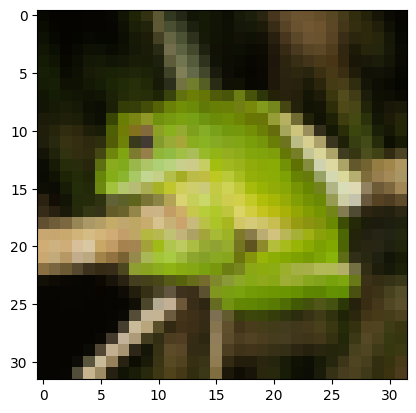

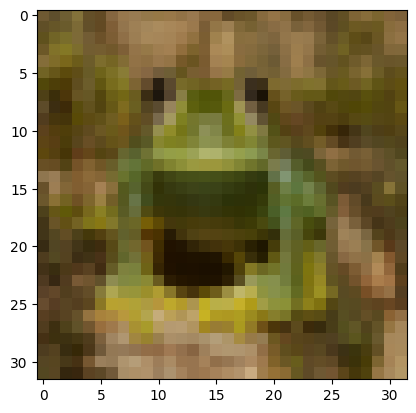

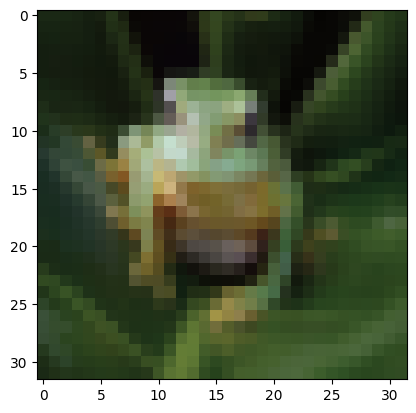

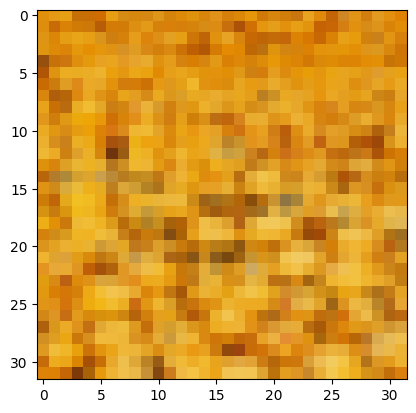

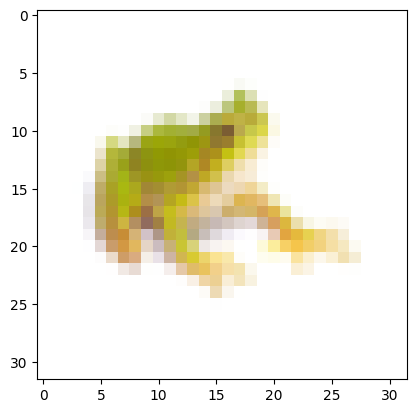

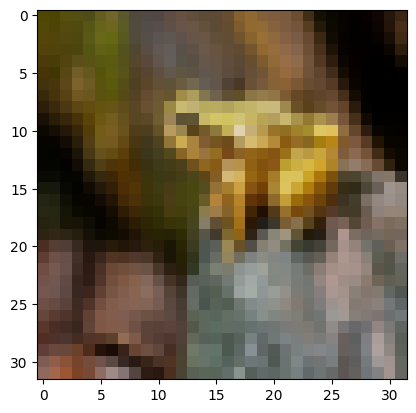

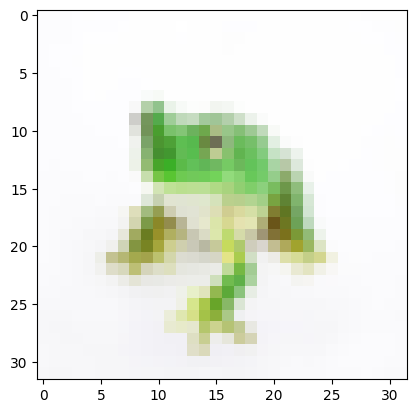

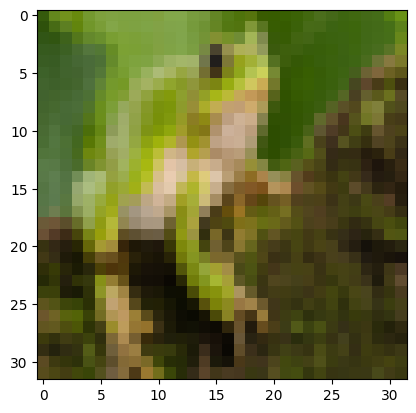

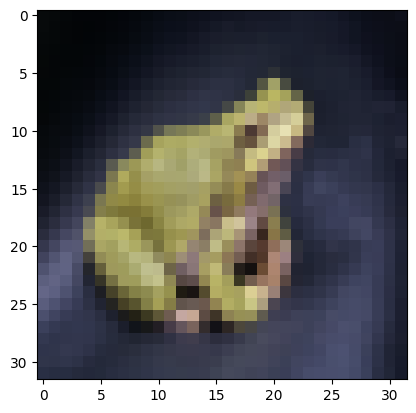

In [34]:
path = r"C:\Users\Safiy\Dokumenter\INFO284\Semester Assignment\pictures" # specify the path to your image folder

# define the image transforms
image_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)), # resize the image to 32x32 pixels
    transforms.ToTensor(), # convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize the pixel values to be between -1 and 1
])

# loop over all the files in the directory
for file in os.listdir(path):
    # load the image using OpenCV
    img = cv2.imread(os.path.join(path, file))
    # convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # apply the image transforms
    img_tensor = image_transforms(img)
    img_tensor = img_tensor.unsqueeze(0)
    img_tensor = img_tensor.to(dev)
    output = clf(img_tensor)
    pred = torch.argmax(output)
    # check if the predicted class label is 1
    if pred == 1:
        # display the image
        imshow(torchvision.utils.make_grid(img_tensor))    

#### References:

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

https://www.kaggle.com/code/shadabhussain/cifar-10-cnn-using-pytorch

https://www.getyourguide.careers/posts/what-makes-a-good-f1-score

https://hackmd.io/@antolaga/H1rGPefeK

https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/